In [1]:
%load_ext autoreload
%autoreload 2

import os
from PIL import Image, ImageOps
import requests
import torch
import matplotlib.pyplot as plt
import numpy as np

import torch
import requests
from tqdm import tqdm
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline
import torchvision.transforms as T

from utils import preprocess, prepare_mask_and_masked_image, recover_image

/mnt/cfs/home/hadi/.conda/envs/open_clip/lib/python3.10/site-packages/tqdm-4.64.0-py3.10.egg/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
to_pil = T.ToPILImage()

### First lets instantiate an inpainting stable diffusion model

In [3]:
# make sure you're logged in with `huggingface-cli login` - check https://github.com/huggingface/diffusers for more details

pipe_inpaint = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    revision="fp16",
    torch_dtype=torch.float16,
)
pipe_inpaint = pipe_inpaint.to("cuda")

Fetching 15 files: 100%|██████████| 15/15 [00:00<00:00, 2651.83it/s]


### The image to fake

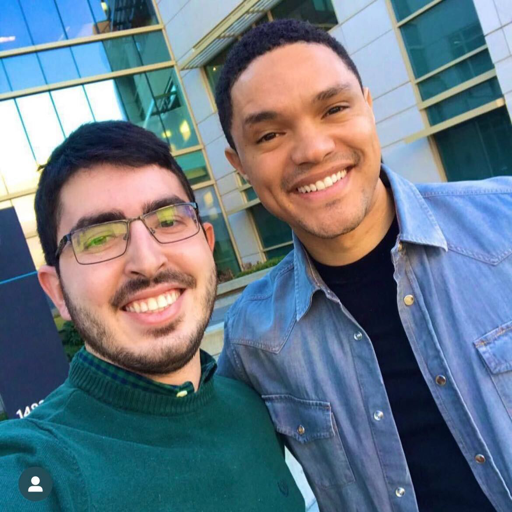

In [4]:
init_image = Image.open(f'../assets/trevor_5.jpg').convert('RGB').resize((512,512))
mask_image = Image.open(f'../assets/trevor_5.tif').convert('RGB')
mask_image = ImageOps.invert(mask_image).resize((512,512))

init_image

### Running Stable Diffusion Inpainting

In [7]:
# prompt = "man riding a motorcycle at night"
# prompt = "two men in a wedding"
# prompt = "two men in a restaurant hugging"
# prompt = "two men in a classroom"
# prompt = "two men in a library"
prompt = "two men in the plane hugging"


# A good seed
SEED = 9209

# Uncomment the below to generated other images
# SEED = np.random.randint(low=0, high=100000)

torch.manual_seed(SEED)
print(SEED)

strength = 0.7
guidance_scale = 7.5
num_inference_steps = 100

image_nat = pipe_inpaint(prompt=prompt, 
                     image=init_image, 
                     mask_image=mask_image, 
                     eta=1,
                     num_inference_steps=num_inference_steps,
                     guidance_scale=guidance_scale,
                     strength=strength
                    ).images[0]
image_nat = recover_image(image_nat, init_image, mask_image)

9209
tensor(456., device='cuda:0', dtype=torch.float16)


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


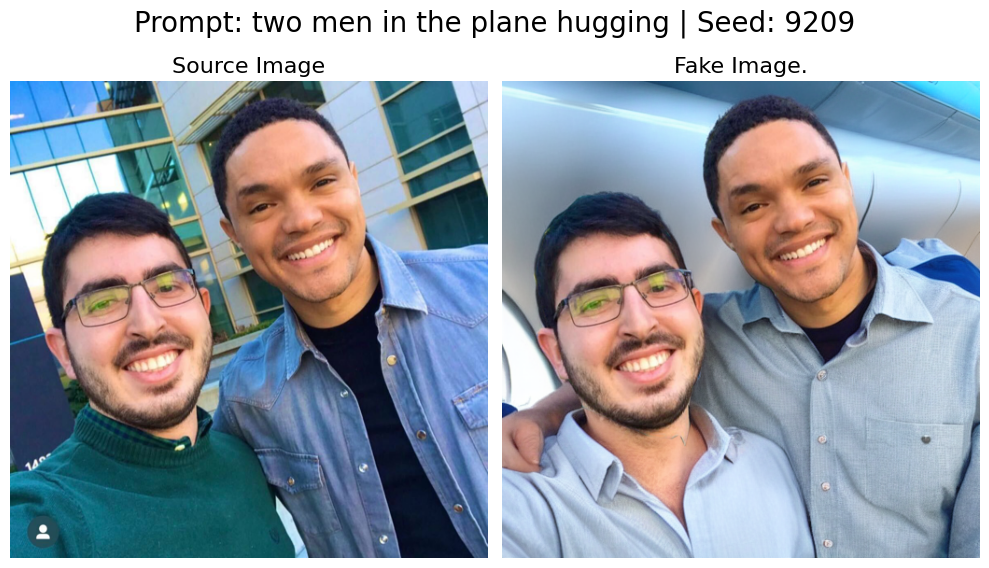

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

ax[0].imshow(init_image)
ax[1].imshow(image_nat)

ax[0].set_title('Source Image', fontsize=16)
ax[1].set_title('Fake Image.', fontsize=16)

for i in range(2):
    ax[i].grid(False)
    ax[i].axis('off')
    
fig.suptitle(f"Prompt: {prompt} | Seed: {SEED}", fontsize=20)
fig.tight_layout()
plt.show()